
# K-means Clustering

## This program performs K-means clustering on the Flu dataset.


### Mount Google Drive if working on google colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Change directory to a path where data is located with respect to the code

In [ ]:
%cd /content/drive/My\ Drive/clustering

### Install packages

In [3]:
!pip3 install numpy
!pip3 install pandas
!pip3 install scikit-learn
!pip3 install seaborn
!pip3 install matplotlib
!pip3 install scipy
!pip3 install statistics

  Created wheel for statistics: filename=statistics-1.0.3.5-cp36-none-any.whl size=7454 sha256=2e36502838faeb596c4f92426c17f6540977733cf21faf1e226959b6a14cb7fb
  Stored in directory: /root/.cache/pip/wheels/75/55/90/73aa7662bfb4565b567618547a275f01372a678ca92ecd64f3
Successfully built statistics


## Import Libraries

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import matplotlib.pyplot as plt
from pprint import pprint
from mpl_toolkits.mplot3d import Axes3D
import math
from collections import defaultdict
from scipy.spatial import distance
%matplotlib inline

## Load dataset

In [7]:
df = pd.read_csv('Assignment-I/Assignment1_data.csv') # change to the path where the data is stored

In [8]:
df.head()

,Student,Vaccin,HndWshQual,HndWshFreq,SociDist,NoFaceContact,RespEttiqu,PersnDist,HandSanit,Risk,Complications,Barriers,Inefficacy,KnowlTrans,KnowlMgmt,Sick,Flu,Female
0,1,3,4,4,2,1,5,1,1,-0.770,-1.453,0.000,0.929,-0.554,0.000,0.0,0.0,1.0
1,2,2,4,4,5,2,5,4,4,-0.345,0.000,-0.489,0.149,-0.554,1.482,1.0,0.0,0.0
2,3,3,2,2,2,3,2,2,1,-0.406,-0.575,-0.234,0.693,-0.182,-1.482,0.0,0.0,0.0
3,4,3,3,2,2,2,5,3,1,-0.575,-0.197,-0.429,0.000,0.554,0.000,2.0,1.0,NaN
4,5,2,5,3,3,2,5,5,3,0.000,-0.770,0.097,0.546,0.554,0.684,1.0,0.0,0.0


### KMeans Class block. In this block are defined class 'KMeans' and functions for performing K-means clustering. For each problem in the assignment, an object of the clustering algorithm is instantiated

In [9]:
# Function to extract features along with the data points
# the function accepts list of features and returns data with only these features
def _extractFeatures(features):
  df_cluster = df[features].dropna()
  return df_cluster

# Method to compute dunn index when passed records (with their cluster label) and centroids (with their cluster labels)
def _computeDunnIndex(records, centroids):
  # Compute inter cluster distances
  list_centroids = list(centroids.values())
  smallest_inter_cluster_dist = 1000000  # Assuming smallest inter-cluster distance can't be over 100000
  for idx, current_cent in enumerate(list_centroids):
    for next_cent in list_centroids[idx+1:]:
      dist = distance.euclidean(current_cent, next_cent)
      if dist < smallest_inter_cluster_dist:
        smallest_inter_cluster_dist = dist

  # Computer intra-cluster distances
  # Iterate through the records
  largest_intra_cluster_dist = 0.0
  for cluster_label, points in records.items():
    for point in points:
      dist = distance.euclidean(point,centroids[cluster_label])
      if dist > largest_intra_cluster_dist:
        largest_intra_cluster_dist = dist

  dunn_idx = float(smallest_inter_cluster_dist)/largest_intra_cluster_dist
  return dunn_idx

# Class KMeans which perfoms clustering when passed number of clusters, the data to cluster and centroid change detection threshold
class KMeans:
  def __init__(self, k, data, eps):
    self.k = k     # number of clusters
    self.data = data     # data to cluster---in dataframe
    self.eps = eps     # smallest distance between a new and old centroid
  # Method to perform K-means clustering----using 'k', the data to cluster, and the threshold for convergence
  def _kMeans(self):      
    record_clusterLabel = defaultdict(list)  #dictionary for mapping for a cluster label and list of the records
    centroid_clusterLabel = {}

    data_std = StandardScaler().fit_transform(self.data)
    
    centroids = data_std[:self.k]   # randomly selected the first k points as the centroids

    for centroid_idx, center in enumerate(centroids):
      centroid_clusterLabel[centroid_idx] = center  # each centroid is tied to a cluster label
      centroid_idx += 1

    nearest_distance = 10000 #randomly set distance high enough to compare proximity between records and centroids

    while True:
      for r in data_std:
          for cluster_idx, c in centroid_clusterLabel.items():
            dist = distance.euclidean(r, c)
            if dist < nearest_distance:
                new_cluster_label = cluster_idx   #new cluster label assigned based on the euclidean distance
                
                record_clusterLabel[new_cluster_label].append(r)  #a record is assigned a new cluster label based on its proximity to a centroid

            nearest_distance = dist   #nearest_distance updates with each iteration over the centroids
      
      # when all clusters have converged, minimial_centroid_change will equal total number of clusters
      minimal_centroid_change = 0  # to keep track of distances between new centroid and old centroid when they are below a certain threshold
      for cluster_idx,c in centroid_clusterLabel.items():
        # difference between old centroid and to-be-computed centroid
        diff = distance.euclidean(np.array(c), np.array(np.mean(record_clusterLabel[cluster_idx], axis=0)))
        if diff < self.eps:
          minimal_centroid_change += 1
        # if all centroids are showing insignificant change in unison, return the records and centroids mappings 
        if minimal_centroid_change == self.k:
          return record_clusterLabel, centroid_clusterLabel   #return mapping to the calling program
        
        # if all centroids haven't converged, go onto computing the new centroid and loop over
        else:
          centroid_clusterLabel[cluster_idx] = np.mean(record_clusterLabel[cluster_idx], axis=0)
    return record_clusterLabel, centroid_clusterLabel   #return mapping to the calling program


### Feature Extraction for the three initial features and raw data distribution visualization using scatter plot before K-means clustering

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


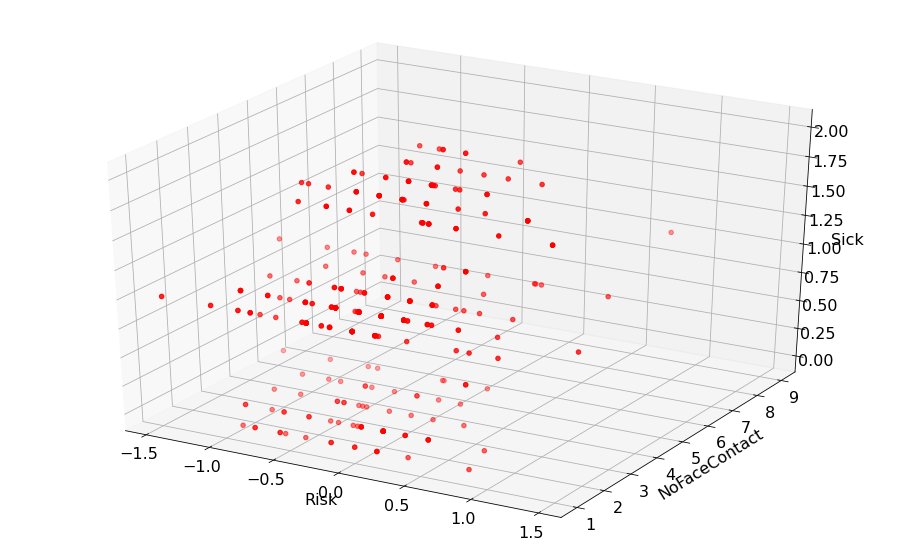

In [10]:
# Features to extract
features = ['Risk', 'NoFaceContact', 'Sick']  # Features for problem 1a

# Call to method extracting data with features to work with
df_cluster = _extractFeatures(features)   # the raw data to perform clustering on before standardizing

font = {'family' : 'normal',
        'size'   : 16}

plt.rc('font', **font)

fig = plt.figure(figsize = (16, 10))
ax = fig.add_subplot(111, projection='3d')

x, y, z = df_cluster['Risk'], df_cluster['NoFaceContact'], df_cluster['Sick']

ax.scatter(x, y, z, c='r', marker='o')

ax.set_xlabel('Risk')
ax.set_ylabel('NoFaceContact')
ax.set_zlabel('Sick')

plt.show()

### Perform clustering by making a call to the kMeans clustering method with K=2 and the three features (Problem 1a)

In [11]:
# call to the K-means clustering method
K1 = KMeans(2, df_cluster, 0.0005)
records, centroids = K1._kMeans()

In [31]:
(list(centroids.keys()))

[0, 1]

### Scatter Plotting after K-means clustering. The centroids are marked with an '*' while the records are marked with solid 'o'

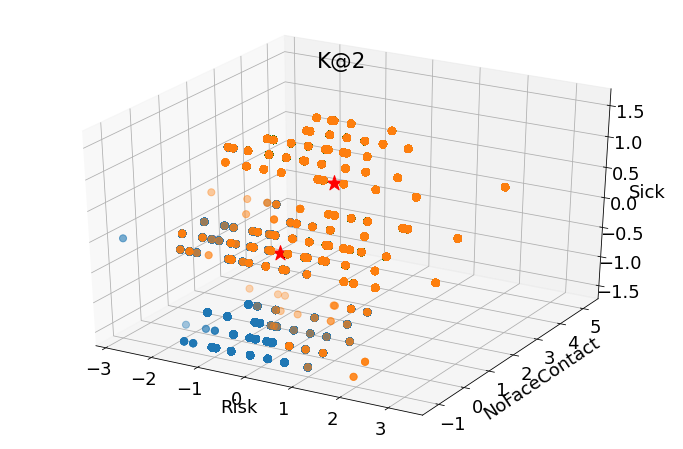

In [33]:
font = {'family' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

fig = plt.figure(figsize = (12, 8))
ax = plt.axes(projection = '3d')

labels = list(centroids.keys())

seed_color = 15
for cluster in records:
  x, y, z = [], [], []
  for point in records[cluster]:
    x.append(point[0]); y.append(point[1]); z.append(point[2])
  
  #ax.scatter3D(x,y,z, c=z, s=50)
  ax.scatter3D(x,y,z, s=50, cmap='viridis')
  ax.scatter3D(centroids[cluster][0],centroids[cluster][1],centroids[cluster][2], c='r', marker='*', s=250, label=f"centroid-{cluster}", )
  #ax.scatter3D(centroids[cluster][0],centroids[cluster][1],centroids[cluster][2], c=K1.labels_.astype(float), marker='*', s=250, label=f"centroid-{cluster}")
  ax.set_xlabel('Risk')
  ax.set_ylabel('NoFaceContact')
  ax.set_zlabel('Sick')
  ax.set_title("K@{}".format(2))


### Looking at the location of the centroids

In [34]:
print(centroids)

{0: array([-0.05469992, -0.15096307, -0.06755484]), 1: array([0.79278715, 0.37114811, 1.05863196])}


### Assessing cluster quality using dunn index

In [35]:
print(_computeDunnIndex(records, centroids))

0.297535558316663


### Running K-means clustering for different numbers of clusters (K=2 to K=10) and visualizing using scatter plot (Problem 1b)

<Figure size 576x432 with 0 Axes>

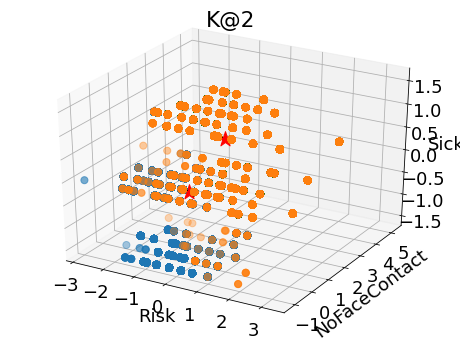

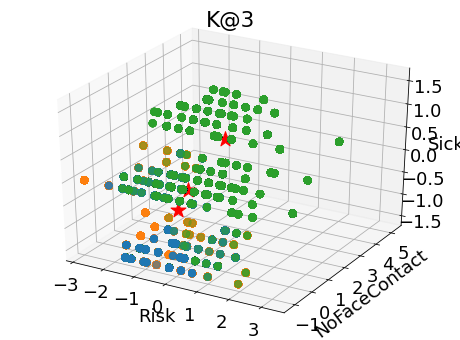

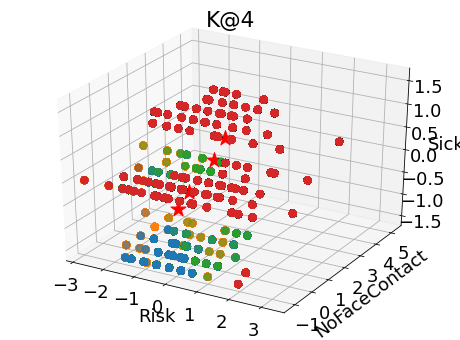

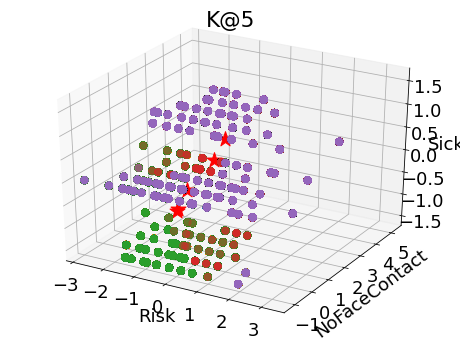

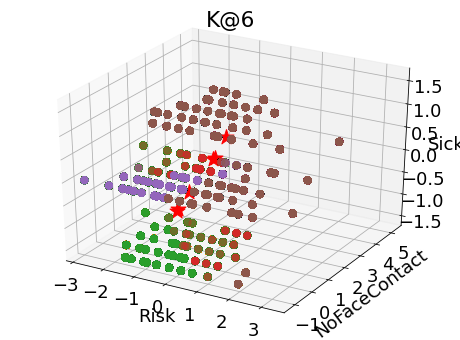

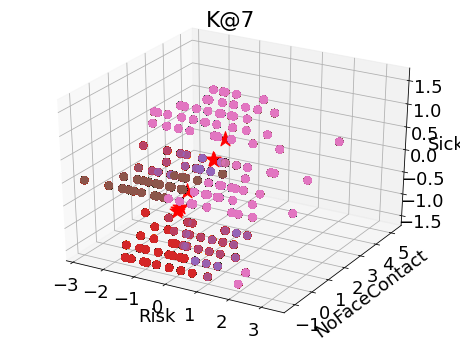

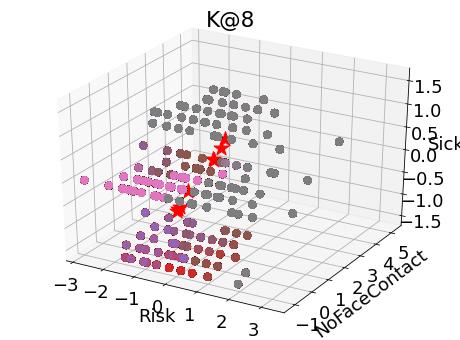

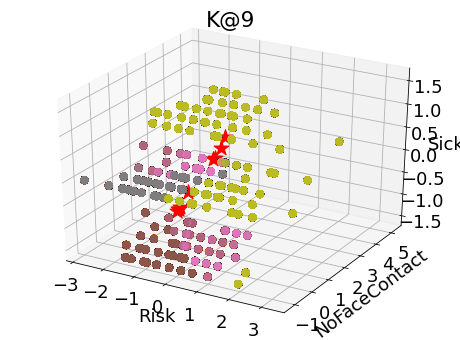

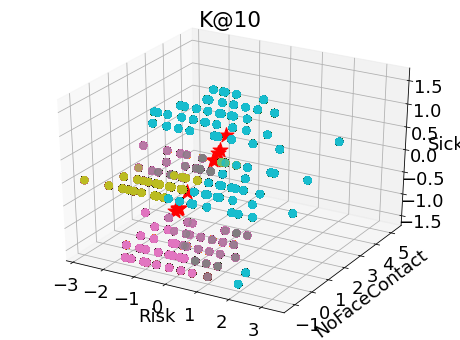

In [36]:
font = {'family' : 'normal',
        'size'   : 8}

fig = plt.figure(figsize = (8, 6))

for k in range(2, 11):
  fig = plt.figure(figsize = (8, 6))

  ax = plt.axes(projection = '3d')
  #records, centroids = _kMeans(k, df_cluster, 0.005)
  K1 = KMeans(k, df_cluster, 0.0005)   # instantiate for each round of value from K@2 to K@10
  records, centroids = K1._kMeans()   # call to clustering method
  seed_color = 15
  for cluster in records:
    x, y, z = [], [], []
    for point in records[cluster]:
      x.append(point[0]); y.append(point[1]); z.append(point[2])
    
    ax.scatter3D(x,y,z, s=50, cmap='viridis')
    ax.scatter3D(centroids[cluster][0],centroids[cluster][1],centroids[cluster][2], c='r', marker='*', s=250, label=f"centroid-{cluster}")
    ax.set_xlabel('Risk')
    ax.set_ylabel('NoFaceContact')
    ax.set_zlabel('Sick')
  ax.set_title("K@{}".format(k))
  plt.show()
    #ax.legend()

  


## Running K-means clustering for K=2 to K=10 and computing dunn index (Problem 1c)

In [ ]:
for k in range(2, 11):
  K1 = KMeans(k, df_cluster, 0.0005)
  records, centroids = K1._kMeans()
  #records, centroids = _kMeans(k, df_cluster, 0.0005)
  print("k:{}".format(k), _computeDunnIndex(records, centroids))


k:2 0.297535558316663
k:3 0.10574030597797059
k:4 0.09728813917862217
k:5 0.0641248874145796
k:6 0.030838348954903724
k:7 0.027146365606845087
k:8 0.030077811676194766
k:9 0.025813280611696774
k:10 0.009626738451367831


## Running K-means clustering with different features (Problem 2a)

In [ ]:
features = ['Risk', 'NoFaceContact', 'Sick', 'HandSanit']   # Added feature 'HandSanit'
df_cluster = _extractFeatures(features)
k_best = 2   # This is determined from the previous section (Problem 1c)

K2 = KMeans(k_best, df_cluster, 0.0005)
records, centroids = K2._kMeans()

# Cluster quality using dunn index
print(_computeDunnIndex(records, centroids))

0.2757393956117485


## Running K-means clustering with different features (Problem 2b)

In [ ]:
features = ['Risk', 'NoFaceContact', 'Sick', 'HandSanit', 'HndWshQual']   # Added feature 'HndWshQual'
df_cluster = _extractFeatures(features)
k_best = 2   # This is determined from the previous section (Problem 1c)

K2 = KMeans(k_best, df_cluster, 0.0005)
records, centroids = K2._kMeans()

# Cluster quality using dunn index
print(_computeDunnIndex(records, centroids))

0.2811042259738486
